# Credits
This notebook is based on original work by [Michael Katz](https://github.com/mikekatz04). The original version can be found in the [LATW](https://github.com/mikekatz04/LATW) repository, licensed under the [Apache License 2.0](https://www.apache.org/licenses/LICENSE-2.0).<br>
My modifications and solutions are for educational purposes as part of my Master's thesis project.

# Tutorial 4: MBHBs & MCMC

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful

In the fourth tutorial we will examine MBHB waveforms. We will examine how to generate waveforms, add the LISA response, calculate the Likelihood, and then we will run an MCMC with MBHBs. 

## Task 1: Generate IMRPhenomHM waveforms

We will start by generating IMRPhenomHM waveforms for MBHBs. Pick reasonable parameters, build a waveform and plot it against the LISA Sensitivity Curve (`LISASens`) in the characteristic strain representation. **Hint**: set `f_ref = 0.0`. You can access the information after waveform generation as attributes on the class. This may be updated

Useful documentation:
* [PhenomHMAmpPhase](https://mikekatz04.github.io/BBHx/html/user/waveforms.html#bbhx.waveforms.phenomhm.PhenomHMAmpPhase)

In [2]:
# imports 
from lisatools.sensitivity import get_sensitivity
from bbhx.waveforms.phenomhm import PhenomHMAmpPhase


No CuPy or GPU PhenomHM module.
No CuPy or GPU interpolation available.


In [3]:
# clear (for internal clearing of answers)
 
wave_gen = PhenomHMAmpPhase()

m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
t_ref = 1e6 # seconds
length = 1024

wave_gen(m1, m2, chi1, chi2, dist, phi_ref, f_ref, t_ref, length)

Text(0, 0.5, 'Characteristic Strain')

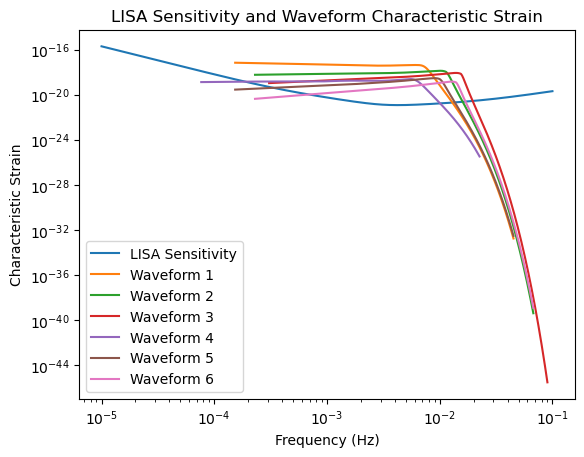

In [4]:
# clear (for internal clearing of answers)
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="LISASens", return_type="char_strain") 
plt.loglog(fn, Sn_char_strain, label="LISA Sensitivity")


for i in range(6):
    char_strain = wave_gen.freqs_shaped[0, i] * wave_gen.amp[0, i]
    plt.loglog(wave_gen.freqs_shaped[0, i], char_strain, label=f"Waveform {i+1}")


plt.legend()
plt.title("LISA Sensitivity and Waveform Characteristic Strain")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Characteristic Strain")

In [5]:
wave_gen.freqs_shaped

array([[[1.53288311e-04, 1.54142487e-04, 1.55001423e-04, ...,
         4.46181243e-02, 4.48667520e-02, 4.51167652e-02],
        [2.29932467e-04, 2.31213731e-04, 2.32502134e-04, ...,
         6.69271865e-02, 6.73001281e-02, 6.76751478e-02],
        [3.06576623e-04, 3.08284975e-04, 3.10002846e-04, ...,
         8.92362486e-02, 8.97335041e-02, 9.02335304e-02],
        [7.66441557e-05, 7.70712436e-05, 7.75007115e-05, ...,
         2.23090622e-02, 2.24333760e-02, 2.25583826e-02],
        [1.53288311e-04, 1.54142487e-04, 1.55001423e-04, ...,
         4.46181243e-02, 4.48667520e-02, 4.51167652e-02],
        [2.29932467e-04, 2.31213731e-04, 2.32502134e-04, ...,
         6.69271865e-02, 6.73001281e-02, 6.76751478e-02]]],
      shape=(1, 6, 1024))

## Task 2: Add the response. 

Now repeat the same task as above by adding the response. In `BBHx`, the response is added automatically for you using the main waveform production class: `BBHWaveformFD`. The sensitivity for this should be `A1TDISens`.

Useful Documentation:
* [BBHWaveformFD](https://mikekatz04.github.io/BBHx/html/user/main.html#bbhx.waveformbuild.BBHWaveformFD)

In [6]:
# imports
from bbhx.waveformbuild import BBHWaveformFD

No CuPy
No CuPy or GPU response available.


In [7]:
# clear (for internal clearing of answers)
 
tdi_wave_gen = BBHWaveformFD()

In [8]:
# clear (for internal clearing of answers)
 
m1 = 2e6
m2 = 7e5
chi1 = 0.5
chi2 = 0.7
dist = 15 * 1e9 * PC_SI
phi_ref = 0.6
f_ref = 0.0
inc = np.pi / 8
lam = 3.4
beta = -0.7
psi = np.pi/4
t_ref = 1e6 # seconds

length = 1024

# setup data holders
Tobs = YRSID_SI / 12.  # 1 month
dt = 10.0  # sec
N = int(Tobs / dt)
Tobs = N * dt

freqs = np.fft.rfftfreq(N, dt)

AET = tdi_wave_gen(
    m1,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    length=1024, 
    combine=False,  # TODO: check this
    direct=False,
    fill=True,
    squeeze=True,
    freqs=freqs   
)

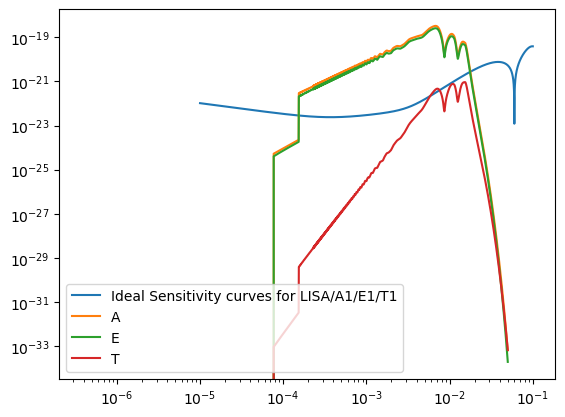

In [9]:
# clear (for internal clearing of answers)
 
fn = np.logspace(-5, -1, 10000)
Sn_char_strain = get_sensitivity(fn, sens_fn="A1TDISens", return_type="char_strain")


plt.loglog(fn, Sn_char_strain, label="Ideal Sensitivity curves for LISA/A1/E1/T1")

#Response generated by BBHWaveformFD
for i, channel in enumerate(["A", "E", "T"]):
    plt.loglog(freqs, freqs * np.abs(AET[0,i]), label=channel)
    
plt.legend()

[-8.87068964e-23 -9.07642605e-23 -9.27935048e-23 ... -8.23743566e-23
 -8.45111152e-23 -8.66222419e-23]
500
1
[0.000e+00 2.000e-05 4.000e-05 ... 4.996e-02 4.998e-02 5.000e-02]


Text(0.5, 0, 'Time [sec]')

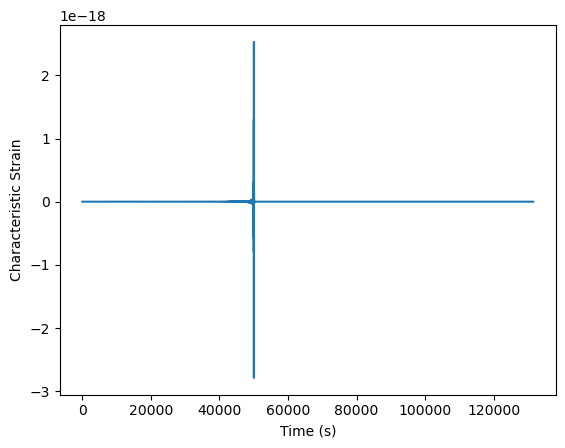

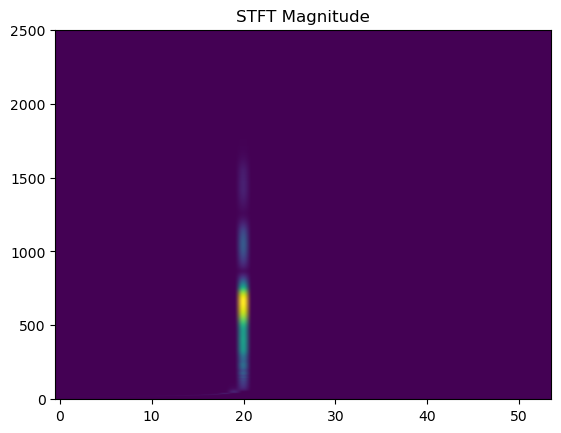

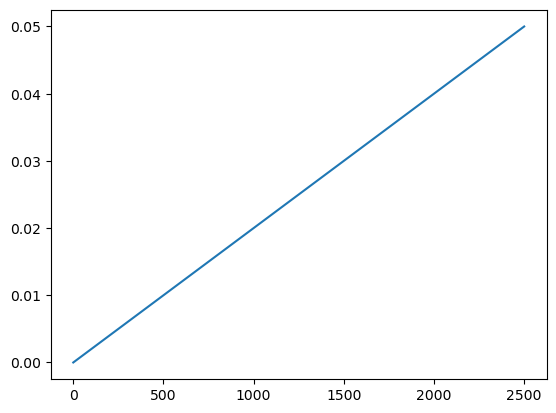

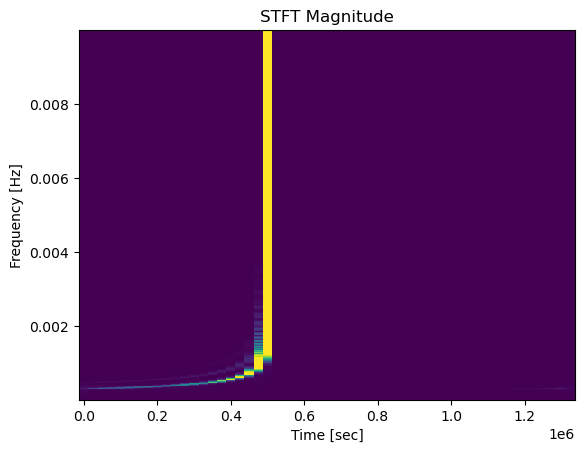

In [ ]:
A_TD = np.real(np.fft.ifft(AET[0,0]))
print(A_TD)
plt.plot(A_TD)
plt.xlabel("Time (s)")
plt.ylabel("Characteristic Strain")
f, t, Zxx = sp.signal.stft(A_TD, fs=1/dt, nperseg=5000)

plt.figure()
plt.imshow(np.abs(Zxx), aspect='auto', origin='lower')
plt.title('STFT Magnitude')

max_freq = 0.01
max_freq_idx = np.searchsorted(f, max_freq)
min_freq = 0.00001
min_freq_idx = np.searchsorted(f, min_freq)
plt.figure()
plt.plot(f)
print(max_freq_idx)
print(min_freq_idx)
print(f)
plt.figure()
plt.pcolormesh(t, f[min_freq_idx:max_freq_idx], np.abs(Zxx[min_freq_idx:max_freq_idx]), vmin=0, vmax= np.max(np.abs(Zxx[min_freq_idx:max_freq_idx]))/10)
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')

## Task 3: Inject an MBHB and compute its SNR

Now we will combine our knowledge of `lisatools` with `bbhx`. Using the same methods above, setup a full `AnalysisContainer` and inject an MBHB signal. Calculate its SNR. 

In [ ]:
# imports
from lisatools.sensitivity import AET1SensitivityMatrix
from lisatools.datacontainer import DataResidualArray
from lisatools.analysiscontainer import AnalysisContainer

In [ ]:
# clear (for internal clearing of answers)

def wrap(*args, **kwargs):
    return tdi_wave_gen(*args, **kwargs)[0]

In [ ]:
# clear (for internal clearing of answers)
 
data = DataResidualArray(AET[0], f_arr=freqs)
sens_mat = AET1SensitivityMatrix(data.f_arr)
analysis = AnalysisContainer(data, sens_mat, signal_gen=wrap)

In [ ]:
# clear (for internal clearing of answers)
 
analysis.snr()

Calculate the Likelihood using `calculate_signal_likelihood`. 

In [ ]:
# clear (for internal clearing of answers)
 
analysis.calculate_signal_likelihood(
    m1 * 1.0001,
    m2, 
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref,
    waveform_kwargs=dict(
        length=1024, 
        combine=False,  # TODO: check this
        direct=False,
        fill=True,
        squeeze=True,
        freqs=freqs
    ),
    source_only=True
    # data_arr_kwargs=dict(f_arr=freqs)
)

## Task 4: MCMC with MBHBs

Now we will run an MCMC for MBHBs. Use your knowledge from our tutorial on `Eryn` to run an MCMC for MBHBs. Let's run it for over four parameters: `(mT, q, phi_ref, t_ref)`. You can use an `Eryn` [TransformContainer](https://mikekatz04.github.io/Eryn/html/user/utils.html#transformcontainer) or a wrapper Likelihood to fill in fixed parameters and make necessary transformations. **Remember**: the waveform generator takes `m1` and `m2`, so you will need to transform these inside the Likelihood function. You can use the `periodic` kwarg for `EnsembleSampler` to run `phi_ref` as a periodic variable wrapping over the edge.

This will not be fast. Run the sampler for a small number of samples and move on to the next step. 

mT = m1 + m2 = Total Mass 

q  = m2 / m1 = Mass Ratio

In [ ]:
# imports
from eryn.ensemble import EnsembleSampler
from eryn.prior import ProbDistContainer, uniform_dist
from eryn.state import State

In [ ]:
# clear (for internal clearing of answers)
 
def wrapper_likelihood(x, fixed_parameters, freqs, analysis, **kwargs):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)
    all_parameters[8] = x[2]
    all_parameters[9] = x[3]
    all_parameters[-1] = x[4]

    all_parameters[np.array([2, 3, 4, 5, 6, 7, 10])] = fixed_parameters

    ll = analysis.calculate_signal_likelihood(
        *all_parameters,
        waveform_kwargs=dict(
            length=1024, 
            combine=False,  # TODO: check this
            direct=False,
            fill=True,
            squeeze=True,
            freqs=freqs
        ),
        source_only=True
        # data_arr_kwargs=dict(f_arr=freqs)
    )
    return ll

In [ ]:
# clear (for internal clearing of answers)
 
priors = {"mbh": ProbDistContainer({
    0: uniform_dist(1e5, 5e6),
    1: uniform_dist(0.05, 0.999999),
    2: uniform_dist(0.0, 2 * np.pi),
    3: uniform_dist(-np.pi/2, np.pi/2),
    4: uniform_dist(0.0, Tobs + 24 * 3600.0),
})}

injection_params = np.array([
    m1 + m2,
    m2 / m1,
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    lam,
    beta,
    psi,
    t_ref
])

fixed_parameters = np.array([
    chi1,
    chi2,
    dist, 
    phi_ref,
    f_ref, 
    inc,
    psi
])

periodic = {"mbh": {2: 2 * np.pi}}

ntemps = 10
nwalkers = 32
ndims = {"mbh": 4}
sampler = EnsembleSampler(
    nwalkers,
    ndims,
    wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, analysis),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    nleaves_max=dict(mbh=1),
    periodic=periodic
)

In [ ]:
# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, lam, beta, t_ref])
print(injection_params_sub)
start_params = injection_params_sub[None, None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)


# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, injection_params_sub.shape[0]))
start_state = State({"mbh": start_params})
sampler.compute_log_prior(start_state.branches_coords)
sampler.run_mcmc(start_state, 10, progress=True)

## Task 5: Add heterodyning for speed

That would take a long time to complete a sampling run. One technique for speeding up waveforms is called `heterodyning`. Wrap the Heterodyned likelihood to use a subset of parameters. You can also use an Eryn `TransformFunction`. 

Useful Documentation:

* [HeterodynedLikelihood](https://mikekatz04.github.io/BBHx/html/user/like.html#bbhx.likelihood.HeterodynedLikelihood)

In [ ]:
# imports
from bbhx.likelihood import HeterodynedLikelihood

In [ ]:
# clear (for internal clearing of answers)
 
# how many frequencies to use
length_f_het = 128

mT = injection_params[0]
q = injection_params[1]

transformed_injection_params = injection_params.copy()
transformed_injection_params[0] = mT / (1 + q)
transformed_injection_params[1] = mT * q / (1 + q)
# initialize Likelihood
like_het = HeterodynedLikelihood(
    tdi_wave_gen,
    freqs,
    data[:],
    transformed_injection_params,
    length_f_het,
)

like_het.get_ll(transformed_injection_params[None, :].T)

In [ ]:
# clear (for internal clearing of answers)
 
def het_wrapper_likelihood(x, fixed_parameters, freqs, het_like):
    all_parameters = np.zeros(12)
    mT = x[0]
    q = x[1]
    all_parameters[0] = mT / (1 + q)
    all_parameters[1] = mT * q / (1 + q)

    # 
    all_parameters[5] = x[2]
    all_parameters[-1] = x[3]

    all_parameters[np.array([2, 3, 4, 6, 7, 8, 9, 10])] = fixed_parameters

    ll = like_het.get_ll(all_parameters)
    return ll

In [ ]:
# clear (for internal clearing of answers)
 
ll_comp = wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, analysis)
ll_het = het_wrapper_likelihood(injection_params[np.array([0, 1, 5, 11])], fixed_parameters, freqs, like_het)
print(ll_het, ll_comp)

In [ ]:
# clear (for internal clearing of answers)
 
nwalkers = 32
het_sampler = EnsembleSampler(
    nwalkers,
    ndims,
    het_wrapper_likelihood,
    priors,
    args=(fixed_parameters, freqs, like_het),
    branch_names=["mbh"],
    tempering_kwargs=dict(ntemps=ntemps),
    periodic=periodic
)

In [ ]:
# clear (for internal clearing of answers)
 
injection_params_sub = np.array([m1 + m2, m2 / m1, phi_ref, t_ref])
start_params = injection_params_sub[None, None, None, :] * (1 + 1e-7 * np.random.randn(ntemps, nwalkers, 1, 4))
start_params[:, :, :, 2] %= (2 * np.pi)
het_start_state = State({"mbh": start_params})
het_sampler.backend.reset(*het_sampler.backend.reset_args,**het_sampler.backend.reset_kwargs)
het_sampler.run_mcmc(het_start_state, 1000, burn=200, progress=True)

In [ ]:
# clear (for internal clearing of answers)
 
from chainconsumer import Chain, ChainConsumer, make_sample, Truth
import pandas as pd
samples = het_sampler.get_chain()["mbh"][:, 0].reshape(-1, 4)
df = pd.DataFrame(samples, columns=["mT", "q", "phi_ref", "t_ref"])
c = ChainConsumer()
c.add_chain(Chain(samples=df, name="An Example Contour"))
c.add_truth(Truth(location={"mT": injection_params_sub[0], "q": injection_params_sub[1], "phi_ref": injection_params_sub[2], "t_ref": injection_params_sub[3]}))
fig = c.plotter.plot()

Let's check how well the heterodyning method matches the base likelihood by sampling our prior. You will have to update the reference template for each computation since we are drawing from the prior and may be far away from our true point. You can do this with `HeterodynedLikelihood.init_heterdyne_info`. **Warning**: if you run this next box, it may complicate the above calculations, so be careful the order you run things. This is one reason why I always develop with scripts and the terminal (and often VScode) rather than jupyter notebook.

In [ ]:
# clear (for internal clearing of answers)
 
num = 10
for params in priors["mbh"].rvs(num):
    update_params = injection_params.copy()
    mT = params[0]
    q = params[1]
    m1 = mT / (1 + q)
    m2 = mT * q / (1 + q)
    update_params[np.array([0, 1, 5, 11])] = np.array([m1, m2, params[2], params[3]])
    like_het.init_heterodyne_info(
        update_params
    )
    ll_comp = wrapper_likelihood(params, fixed_parameters, freqs, analysis)
    ll_het = het_wrapper_likelihood(params, fixed_parameters, freqs, like_het)
    print(ll_comp, ll_het, np.abs(ll_comp - ll_het), np.abs(ll_comp - ll_het) / np.abs(ll_comp))